In [1]:
import cv2
import os

In [2]:
def smooth_image(image_path, output_path, kernel_size=(5, 5) , output_dir='enhanced_frames'):
    """
    Apply Gaussian smoothing to an image to increase its quality.

    Parameters:
    image_path (str): Path to the input image.
    output_path (str): Path to save the smoothed image.
    kernel_size (tuple): Size of the Gaussian kernel. Default is (5, 5).
    """
    # Read the image
    image = cv2.imread(image_path)
    
    # Check if the image was successfully loaded
    if image is None:
        print(f"Error: Unable to load image at {image_path}")
        return
    
    # Apply Gaussian smoothing
    smoothed_image = cv2.GaussianBlur(image, kernel_size, 0)

    # Create the enhanced_frames directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    
    # Save the smoothed image
    cv2.imwrite(output_path, smoothed_image)

# print(f"smoothing is done inside output_dir folder")
# Example usage
smooth_image('frames/frame_0152.png', 'enhanced_frames/frame_0152.png')

Extract frames from the video

In [3]:
# Create a directory to store the frames
if not os.path.exists('frames'):
    os.makedirs('frames')

# Open the video file
video_path = './video/film.mp4'
cap = cv2.VideoCapture(video_path)

frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame_filename = f'frames/frame_{frame_count:04d}.png'
    cv2.imwrite(frame_filename, frame)
    frame_count += 1

cap.release()
cv2.destroyAllWindows()

Enhance the frames using gaussian

In [4]:
for i in range(frame_count):
    frame_filename = f'frames/frame_{i:04d}.png'
    enhanced_frame_filename = f'enhanced_frames/frame_{i:04d}.png'
    smooth_image(frame_filename, enhanced_frame_filename,kernel_size=(9,9))

Intialize video colrizer

In [6]:
import os
print(os.getcwd())

/Users/omar/Desktop/College/GP/MVP


In [7]:
%cd DeOldify/

/Users/omar/Desktop/College/GP/MVP/DeOldify


Change this to GPU

In [8]:
#NOTE:  This must be the first call in order to work properly!
from deoldify import device
from deoldify.device_id import DeviceId
#choices:  CPU, GPU0...GPU7
# device.set(device=DeviceId.GPU0)
device.set(device=DeviceId.CPU)

<DeviceId.CPU: 99>

In [10]:
from deoldify.visualize import *
plt.style.use('dark_background')
torch.backends.cudnn.benchmark=True
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*?Your .*? set is empty.*?")

In [11]:
colorizer = get_image_colorizer(artistic=True)

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


## Colorize!!

Test on the first frame

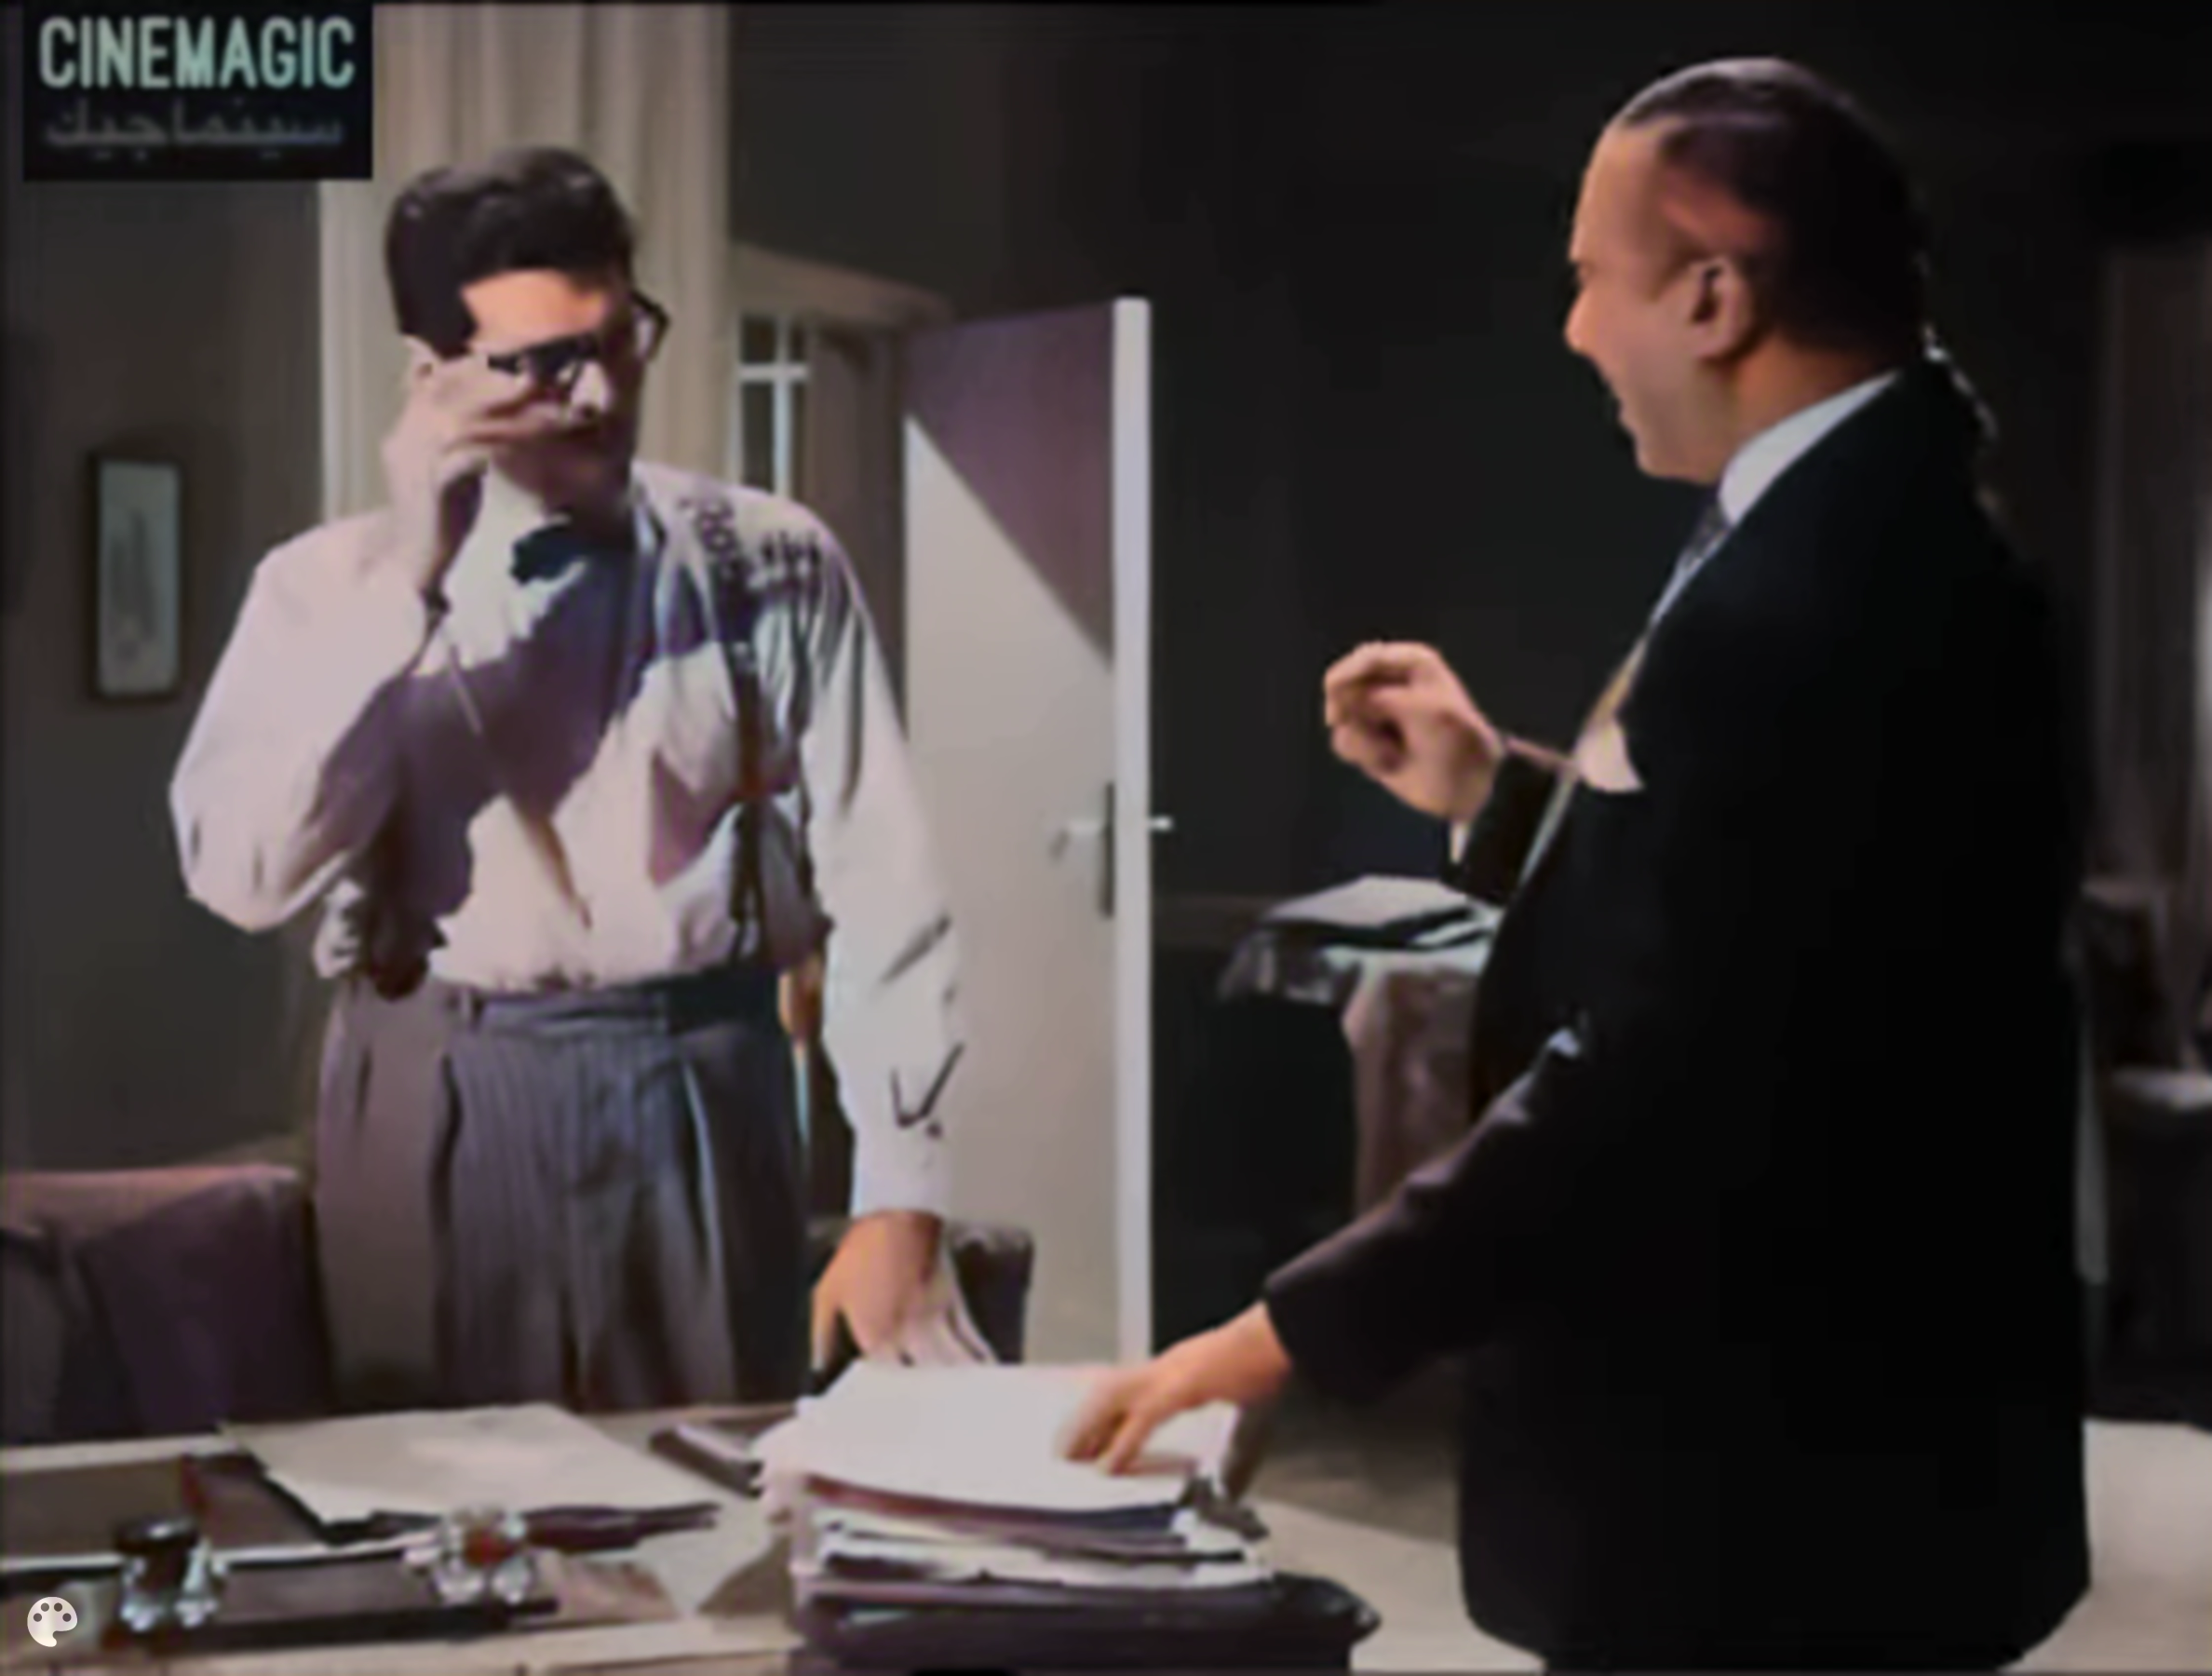

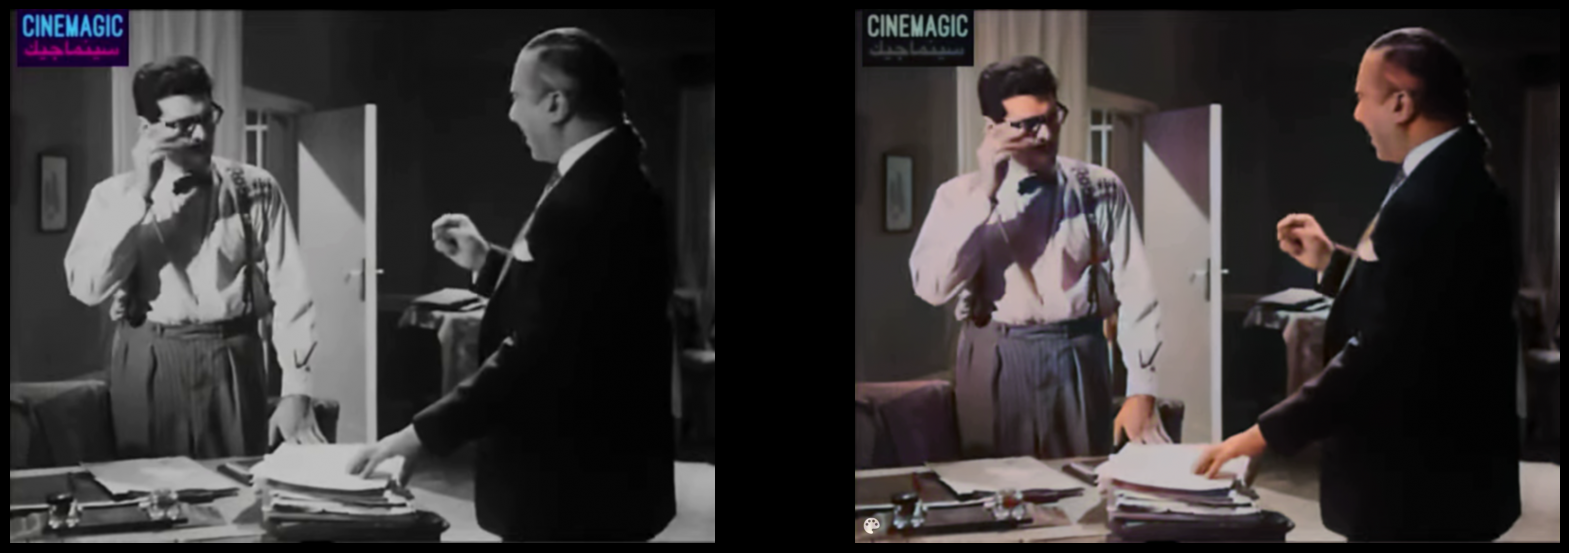

In [12]:
#NOTE:  Max is 45 with 11GB video cards. 35 is a good default
render_factor=35
#NOTE:  Make source_url None to just read from file at ./video/source/[file_name] directly without modification
# source_url='https://upload.wikimedia.org/wikipedia/commons/e/e4/Raceland_Louisiana_Beer_Drinkers_Russell_Lee.jpg'
source_url=None
source_path = 'test_images/frame_0000.png'
result_path = None

if source_url is not None:
    result_path = colorizer.plot_transformed_image_from_url(url=source_url, path=source_path, render_factor=render_factor, compare=True)
else:
    result_path = colorizer.plot_transformed_image(path=source_path, render_factor=render_factor, compare=True)

show_image_in_notebook(result_path)

Error processing frame 0: unsupported operand type(s) for /: 'str' and 'str'
Error processing frame 1: unsupported operand type(s) for /: 'str' and 'str'


KeyboardInterrupt: 

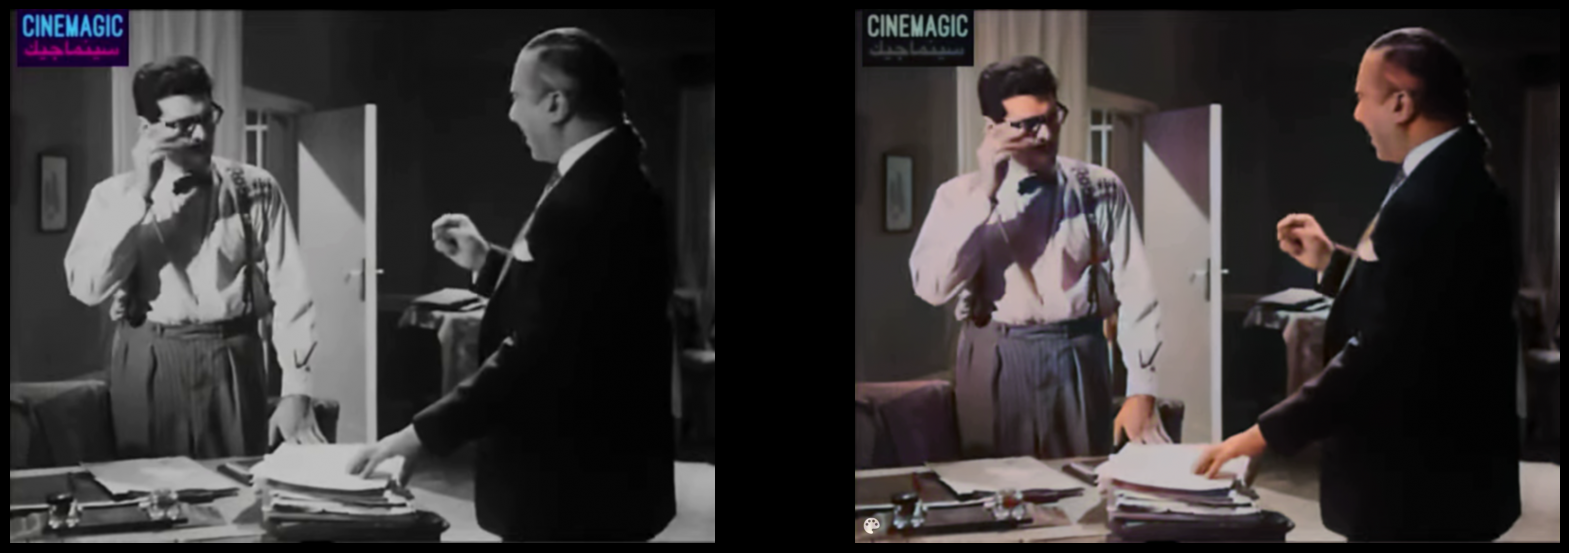

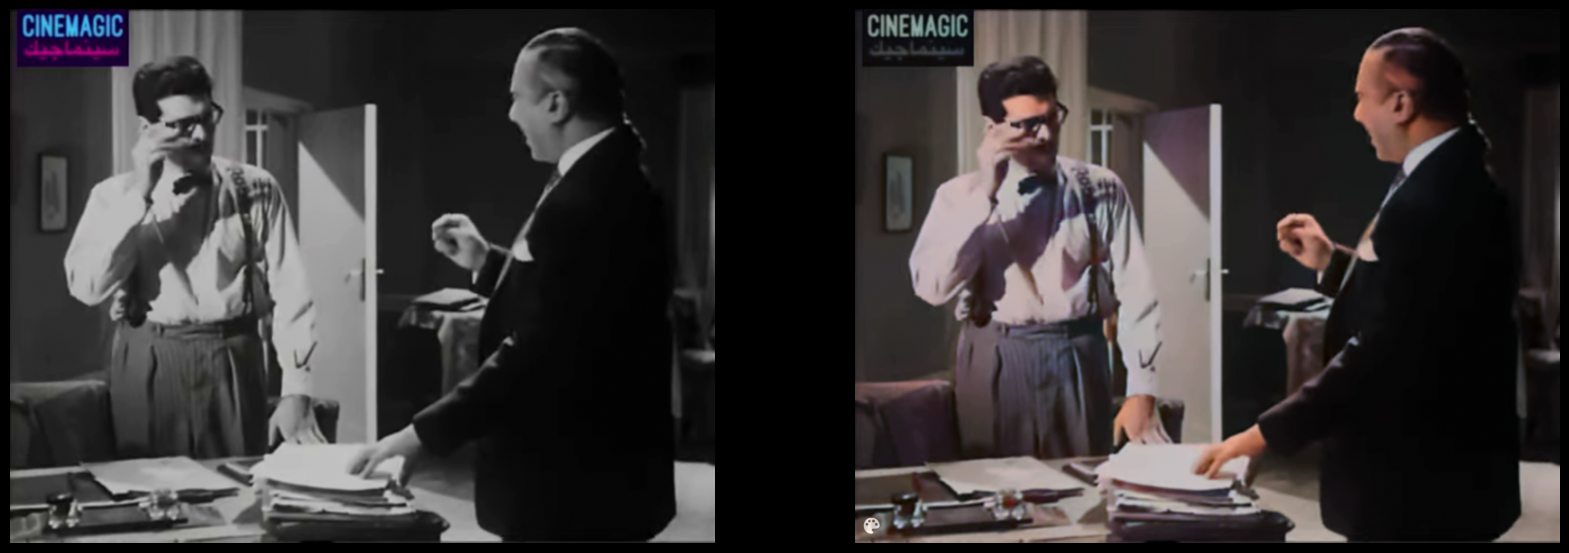

In [18]:
import os

# Create a directory to store the colorized frames
if not os.path.exists('colorized_frames'):
    os.makedirs('colorized_frames')

for i in range(frame_count):
    source_path = f'enhanced_frames/frame_{i:04d}.png'
    result_path = f'colorized_frames/frame_{i:04d}.png'
    try:
        result_path = colorizer.plot_transformed_image(path=source_path, render_factor=render_factor, compare=True, results_dir='colorized_frames')
    except Exception as e:
        print(f"Error processing frame {i}: {e}")

## See how well render_factor values perform on a frame here

In [ ]:
#for i in range(10,46):
    #colorizer.plot_transformed_image(source_path, render_factor=i, display_render_factor=True, figsize=(10,10))

Reconstruct the video from the enhanced frames

In [ ]:
# Open the original video to get its properties
original_video = cv2.VideoCapture(video_path)
fps = original_video.get(cv2.CAP_PROP_FPS)
frame_width = int(original_video.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(original_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
original_video.release()

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can use other codecs as well
out = cv2.VideoWriter('output_video.mp4', fourcc, fps, (frame_width, frame_height))
for i in range(frame_count):
    enhanced_frame_filename = f'enhanced_frames/frame_{i:04d}.png'
    enhanced_frame = cv2.imread(enhanced_frame_filename)
    
    if enhanced_frame is None:
        print(f"Error: Unable to load image at {enhanced_frame_filename}")
        continue
    
    out.write(enhanced_frame)

out.release()
cv2.destroyAllWindows()